# Outline

## Main goal of code: 

### *To find out where disk stars at ~8 kpc in M31's disk end up after the MW/M31 merger*

## Goal breakdown:

1. Learn if M33's gravitational potential affects the stars in a way that MW suns weren't affected in van der Marel et al. 2012
2. Find out if there is any structure to the change of positions of the stars
3. **Focus of Assignment 3: Find out how many, if any, stars end up unbound/ how close candidate suns are to being unbound**

## Data needed for code:

1. At least M31 snapshots 000, 801, and some in between

**High res** or low res?

## Functions needed to complete goal (not necessarily in order)

1. Read in data from text file (ReadFile, HW2)
 - Inputs: complete filename
2. Rotate M31 coords to view galaxy edge on in order to get in-plane velocity (Lab 7 Part B)
 - Inputs: initial [x,y,z] array, initial [vx,vy,vz] array
3. <s>Rotate M31 coords to view galaxy face on in order to better visualize (Lab 7 Part B)</s> 
3. Identify stars in M31_000.txt that fulfill the following conditions:
    1. disk particle
    2. distance within 10% of 8.34 kpc (Lec 4) from the COM (radius range aka RR = 7.506 kpc to 9.174 kpc)
    3. in-plane velocity within 10% of the circular velocity of M31 in this radius range
    4. out-of-plane velocity will be discounted for simplicity's sake? I want stable stars
4. Calculate the total circular velocity at each radius within RR (CircularVelocityTotal, HW5)
5. Calculate the total mass enclosed at each radius within RR (TotalMassEnclosed, HW5)
6. Calculate the mass of a particular compoment at each radius within RR (MassEnclosed, HW5)
7. Calculate the COM position and velocity of M31 (CLASS CenterOfMass, HW4)
 - Inputs: complete filename, particle type
8. Calculate escape velocity for all candidate suns in their final positions (final snapshot tbd)
9. 

## Potential plots

1. stars vs distance away from COM (histogram)
2. **Focus of Assignment 3: # stars vs (total velocity/escape velocity)**
2. Snapshot 000 vs 400 vs 801 (or more) with ring of interest highlighted (like Fig 5 of van der Marel et al. 2012)
3. 

In [1]:
# import necessary modules (copied from HW7 template)
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

#imported functions/classes from labs/hw will go here
from ReadFile import Read
from RotateGalaxy import EdgeRotate
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile

In [2]:
unitsG = const.G.to(u.kpc*u.km**2/u.s**2/u.Msun)

In [3]:
# reading in the data of the 000 snapshot
#time000, totalpart000, data000 = Read("M31_000.txt")

# Saving the indices of all the disk particles
#DiskPartIndex = np.where(data000['type'] == 2) 

# saving the data about just the disk particles in snapshot 000
# DiskPart = data000[DiskPartIndex]

In [4]:
# This function will recenter the position and velocity of disk particles
#    in around the COM of M31 at any snapshot
def RotateSetup(snap):
    # Input:
    #    snap = snapshot number (ex. 0, 14, 38, etc)
    # Returns:
    #    rD = a recentered position array
    #    vD = a recentered velocity array
    
    # this chunk is taken from MassProfile
    # Making the filename
    # Adds extra 0's to start of the inputted snap number
    ilbl = '000' + str(snap)
    # Gets rid of everything but the last 3 digits
    ilbl = ilbl[-3:]
    # Constructs the filename (ex. MW_000.txt) and saves it to a global property
    # The "../../" is for my directory specifically- I have the snapshots saved two folders up
    filename = "M31_" + ilbl + '.txt'
    
    M31COMdisk = CenterOfMass(filename,2)
    
    # Compute COM of M31 using disk particles
    COMP = M31COMdisk.COM_P(0.1)
    COMV = M31COMdisk.COM_V(COMP[0],COMP[1],COMP[2])
    
    # Determine positions of DISK particles relative to DISK COM 
    xD = M31COMdisk.x - COMP[0].value 
    yD = M31COMdisk.y - COMP[1].value 
    zD = M31COMdisk.z - COMP[2].value 

    # Determine velocities of DISK particles relative to DISK COM motion
    vxD = M31COMdisk.vx - COMV[0].value 
    vyD = M31COMdisk.vy - COMV[1].value 
    vzD = M31COMdisk.vz - COMV[2].value 
    
    # Vectors for r and v [disk]
    # transposed (column not row)
    rD = np.array([xD,yD,zD]).T 
    vD = np.array([vxD,vyD,vzD]).T
    
    return rD, vD

In [5]:
# FUNCTION I MADE
# It would probably be easier to put this all in a class so I don't have to move the data array around unnecessarily
# Function will identify M31 disk stars (particle type = 2) that fit selection criteria listed in first cell
# This function will only be needed for snapshot 000
# [USES ROTATED COORDINATES]
def GetStars(rDnew, vDnew):
    # Inputs:
    #    rDnew = array [x,y,z] of rotated, recentered disk particles
    #    vDnew = array [vx,vy,vz] of rotated, recentered disk particles
    # Returns:
    #    an array containing the indeces of particles that fit the selection criteria
    #    for candidate suns
    
    
    # Distance of the sun from the COM of the Milky Way [kpc]
    #    Value from [SCRAPPED Reid et al. 2014] grav paper [lec 4]
    # Making this a variable so it can be easily changed later
    SunR = 8.178
    
    # lower bound of radius range w/in 10% of 8.34 [kpc]
    # written out like this to ensure no calculator errors
    Rlower = SunR - (SunR * 0.1)
    
    # upper bound of radius range [kpc]
    # written out like this to ensure no calculator errors
    Rupper = SunR + (SunR * 0.1)
        
    # Radius range, making an array to eventually send into TotalMassEnclosed
    RR =  np.array([Rlower, Rupper]) * u.kpc
    
    # High end approximation of the sun's distance above the galactic plane [kpc]
    #    30 pc referenced from Majaess 2009 and Seigert 2019
    # This constrains our volume of interest to a rectangular toroid extending above
    #    and below the plane of the galaxy
    SunZ = 0.03
    
    # out of plane velocity of the sun from Schonrich 2010 [km/s]
    SunVz = 7.25
        
    # the magnitude distance of each disk particle from the COM of M31    
    Rmag = np.sqrt(rDnew[:,0]**2 + rDnew[:,1]**2 + rDnew[:,2]**2)
    # print(Rmag)
        
    # calculating the circular velocity of each disk particle that's in the RR
    VCircActual = np.sqrt(vDnew[:,0]**2 + vDnew[:,1]**2)
    # print (VCircActual)
   
    # How to do Vcirc at each radius?
    #    particles within 10% of the Vcirc for their specific distance from the center of mass
    # Earlier brainstorming
    # stuck at M -> it'll be total mass enclosed (see stuck here markdown cell)
    
    # VCirc = np.sqrt(G * Mtotenclosed / Rmag)
    # these circular velocities will be based on M31's mass profile
    # also this puts a lower and upper limit on vCircs that are considered
    # Units are removed so it doesn't yell at me
    VCircRange = M31MassProf0.CircularVelocityTotal(RR) * u.s / u.km
    
    # According to the rotation curve  of M31 found in HW 5, VCirc decreases with radius
    #    in the radius range I am considering
    # Therefore: 
    #    Rlower -> VCircRange[0] -> VCircUpper
    #    Rupper -> VCircRange[1] -> VCircLower
    VCircUpper = VCircRange[0]
    #print("Rlower = ", Rlower)
    #print("VCircUpper = ", VCircUpper)
    VCircLower = VCircRange[1]
    #print("Rlower = ", Rupper)
    #print("VCircLower = ", VCircLower)

    ## a very long np.where
    #    find particles that are type 2 (done by sending in the r and v arrays to this function)
    #    find particle w/ positions that are w/in bounds of RR and the sun's z
    #    find particles w/ in-plane velocities that are w/in bounds of Vcirc
    #    find particles w/ out-of-plane velocities that are less than or equal to the sun's (scrapped for now)
    SunStarIndex = np.where((Rmag > Rlower) & (Rmag < Rupper) & (np.abs(rDnew[:,2]) <= SunZ) \
                            & (VCircActual > VCircLower) & (VCircActual < VCircUpper) ) #\
                            #& (np.abs(vDnew[:,2]) <= SunVz))
    
    return SunStarIndex
    

In [6]:
# This cell is so I don't have to keep redoing the candidate sun selection
# Recentering 0 Gyr
rD0, vD0 = RotateSetup(0)

# Calling EdgeRotate to rotate the coordinate system of the particles
#    The disk is being rotated so I can easily find in-plane velocities 
rDnew0, vDnew0 = EdgeRotate(rD0, vD0)

# Creating an instance of the MassProfile class 
# (uses original file - UNROTATED COORDINATES)
M31MassProf0 = MassProfile("M31", 0)

# Getting the indices of the sun candidates
SunCandidates = GetStars(rDnew0, vDnew0)

In [7]:
# Recentering for all files except the first snapshot
rD3, vD3 = RotateSetup(210)
rD4, vD4 = RotateSetup(280)
rD5, vD5 = RotateSetup(350)
rD6, vD6 = RotateSetup(420)
rD8, vD8 = RotateSetup(560)
rD10, vD10 = RotateSetup(700)

In [8]:
# Calling EdgeRotate to rotate the coordinate system of the particles
#    The disk is being rotated so I can easily find in-plane velocities 
rDnew3, vDnew3 = EdgeRotate(rD3, vD3)
rDnew4, vDnew4 = EdgeRotate(rD4, vD4)
rDnew5, vDnew5 = EdgeRotate(rD5, vD5)
rDnew6, vDnew6 = EdgeRotate(rD6, vD6)
rDnew8, vDnew8 = EdgeRotate(rD8, vD8)
rDnew10, vDnew10 = EdgeRotate(rD10, vD10)

In [9]:
# Creating an instance of the MassProfile class for snaps other than 000
# (uses original file - UNROTATED COORDINATES)
M31MassProf3 = MassProfile("M31", 210)
M31MassProf4 = MassProfile("M31", 280)
M31MassProf5 = MassProfile("M31", 350)
M31MassProf6 = MassProfile("M31", 420)
M31MassProf8 = MassProfile("M31", 560)
M31MassProf10 = MassProfile("M31", 700)

In [10]:
# this function will calculate the magnitude distance and circular velocity of solar candidates
def RmagVCircVmag(rDnew, vDnew):
    # Inputs:
    #    rDnew = recentered and rotated positions of all disk particles
    #    vDnew = recentered and rotated velocities of all disk paricles
    # Returns:
    #    Rmag = array containing the magnitude distances of the solar candidates
    #    Vcirc = array containing the circular velocities of the solar candidates
    
    # mag distance of sun candidates from the COM
    Rmag = np.sqrt(rDnew[SunCandidates,0]**2 + rDnew[SunCandidates,1]**2 + rDnew[SunCandidates,2]**2)
    
    # calculating the circular velocity of each sun candidate
    VCirc = np.sqrt(vDnew[SunCandidates,0]**2 + vDnew[SunCandidates,1]**2)
    
    # calculating the circular velocity of each sun candidate
    Vmag = np.sqrt(vDnew[SunCandidates,0]**2 + vDnew[SunCandidates,1]**2 + vDnew[SunCandidates,2]**2)
    
    return Rmag, VCirc, Vmag

In [11]:
#From HW5, just making a radius array
r0 = np.arange(0.1, 30.1, 0.25) * u.kpc
r3 = np.arange(0.1, 70.1, 0.25) * u.kpc
r4 = np.arange(0.1, 40.1, 0.25) * u.kpc
r8 = np.arange(0.1, 60.1, 0.25) * u.kpc
r10 = np.arange(0.1, 110.1, 0.25) * u.kpc

# array of total Vcirc of M31 
M31VcTot0 = M31MassProf0.CircularVelocityTotal(r0)
M31VcTot3 = M31MassProf3.CircularVelocityTotal(r3)
M31VcTot4 = M31MassProf4.CircularVelocityTotal(r4)
M31VcTot5 = M31MassProf5.CircularVelocityTotal(r8)
M31VcTot6 = M31MassProf6.CircularVelocityTotal(r4)
M31VcTot8 = M31MassProf8.CircularVelocityTotal(r8)
M31VcTot10 = M31MassProf10.CircularVelocityTotal(r10)

In [12]:
# mag distance of sun candidates
RmagSuns0, VCircSuns0, VmagSuns0 = RmagVCircVmag(rDnew0, vDnew0)
RmagSuns3, VCircSuns3, VmagSuns3 = RmagVCircVmag(rDnew3, vDnew3)
RmagSuns4, VCircSuns4, VmagSuns4 = RmagVCircVmag(rDnew4, vDnew4)
RmagSuns5, VCircSuns5, VmagSuns5 = RmagVCircVmag(rDnew5, vDnew5)
RmagSuns6, VCircSuns6, VmagSuns6 = RmagVCircVmag(rDnew6, vDnew6)
RmagSuns8, VCircSuns8, VmagSuns8 = RmagVCircVmag(rDnew8, vDnew8)
RmagSuns10, VCircSuns10, VmagSuns10 = RmagVCircVmag(rDnew10, vDnew10)

In [13]:
# This function will calculate the escape velocity for each candidate sun
# vEsc^2 = 2 abs(Phi)
# Where Phi is the gravitational potential of a Hernquist 1990 mass profile -(G * Menclosed / (r + a)) from Lecture 4
#    following along with feedback on proposal
# Wait but this is lower than it should be
def vEsc(snap, rMag):
    # Inputs:
    #    snap = snapshot number
    #    rMag = array of mag dists. of the cand. suns
    # Returns:
    #    vEsc = array of escape velocities of the cand. suns

    # Scale radius for M31 beyond 5 kpc from the COM found in HW 4
    #    Will this change as the merger is underway?
    a = 62
    
    # using the right object for the snapshot you're looking at
    if snap == 0:
        Menc = (M31MassProf0.TotalMassEnclosed(rMag*u.kpc)).value 
    if snap == 1:
        Menc = (M31MassProf001.TotalMassEnclosed(rMag*u.kpc)).value
    if snap == 210:
        Menc = (M31MassProf3.TotalMassEnclosed(rMag*u.kpc)).value
    if snap == 280:
        Menc = (M31MassProf4.TotalMassEnclosed(rMag*u.kpc)).value
    if snap == 350:
        Menc = (M31MassProf5.TotalMassEnclosed(rMag*u.kpc)).value
    if snap == 420:
        Menc = (M31MassProf6.TotalMassEnclosed(rMag*u.kpc)).value
    if snap == 560:
        Menc = (M31MassProf8.TotalMassEnclosed(rMag*u.kpc)).value
    if snap == 700:
        Menc = (M31MassProf10.TotalMassEnclosed(rMag*u.kpc)).value
        
    # Calculating the vEsc for each candidate sun (ignoring the hernquist part for now)
    vEsc = np.sqrt(np.abs(-2*(unitsG * Menc / (rMag))))

    return (vEsc).value # getting rid of the units too

In [14]:
# This was originally a 2d array with all values in the first element so i'm fixing it
RmagSuns0 = RmagSuns0.flatten()
RmagSuns3 = RmagSuns3.flatten()
RmagSuns4 = RmagSuns4.flatten()
RmagSuns5 = RmagSuns5.flatten()
RmagSuns6 = RmagSuns6.flatten()
RmagSuns8 = RmagSuns8.flatten()
RmagSuns10 = RmagSuns10.flatten()

In [37]:
# calculating the escape velocity for each sun candidate
Vesc0 = vEsc(0,RmagSuns0)
Vesc3 = vEsc(210,RmagSuns3)
Vesc4 = vEsc(280,RmagSuns4)
Vesc5 = vEsc(350,RmagSuns5)
Vesc6 = vEsc(420,RmagSuns6)
Vesc8 = vEsc(560,RmagSuns8)
Vesc10 = vEsc(700,RmagSuns10)

In [42]:
# Note: vCirc = sqrt(GM/r) and vEsc = sqrt(2GM/r)
# vCirc/vEsc = sqrt(1/2) ~ 0.7
CircEsc = np.sqrt(0.5)

0.7071067811865476

In [16]:
# the ratio of the magnitude vector of a star to the escape velocity at its distance away from the COM of M31
# these arrays also need to be flattened
vRatio0 = (VmagSuns0 / Vesc0).flatten()
vRatio3 = (VmagSuns3 / Vesc3).flatten()
vRatio4 = (VmagSuns4 / Vesc4).flatten()
vRatio5 = (VmagSuns5 / Vesc5).flatten()
vRatio6 = (VmagSuns6 / Vesc6).flatten()
vRatio8 = (VmagSuns8 / Vesc8).flatten()
vRatio10 = (VmagSuns10 / Vesc10).flatten()

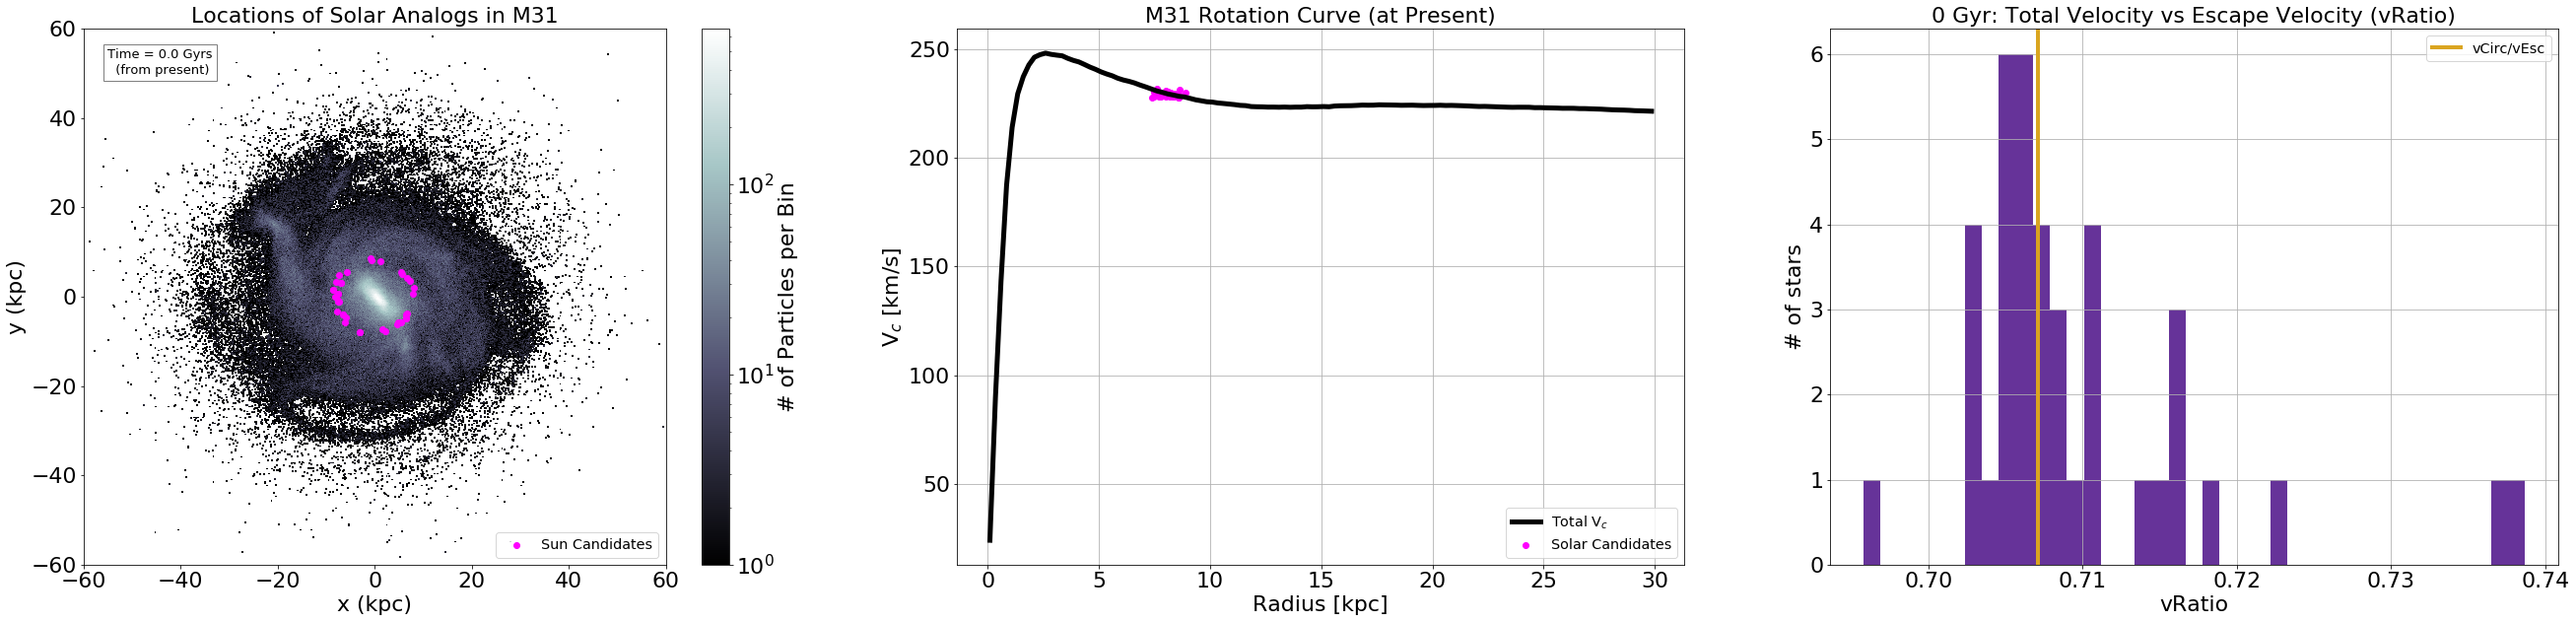

In [92]:
# 0 GYR

# setting up the subplots
fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(45, 10))

# ax[0] = PARTICLE DENSITY AND SOLAR CANDIDATE LOCATION
ax[0].annotate('Time = 0.0 Gyrs\n  (from present)', xy = (-55,50), size=13, bbox=dict(fc="white", ec="gray"))
# plot the particle density for M31 
hist = ax[0].hist2d(rDnew0[:,0], rDnew0[:,1], bins=700, norm = LogNorm(), cmap='bone')
# color coding
colorbar = plt.colorbar(hist[3], ax=ax[0])
# labeling the colorbar
colorbar.ax.set_ylabel('# of Particles per Bin', fontsize=22)
# plotting the candidate suns
ax[0].scatter(rDnew0[SunCandidates,0], rDnew0[SunCandidates,1], c='magenta', label='Sun Candidates')
# Adding a plot title
ax[0].set_title('Locations of Solar Analogs in M31', fontsize=22, loc='center', pad=None)
# Add axis labels
ax[0].set_xlabel('x (kpc)', fontsize=22)
ax[0].set_ylabel('y (kpc)', fontsize=22)
# making the axes equal
#ax[0].set_axis('scaled')
#set axis limits
ax[0].set_ylim(-60,60)
ax[0].set_xlim(-60,60)
# Adding a legend with some customizations.
ax[0].legend(loc='lower right',fontsize='x-large')


# ax[1] = ROTATION CURVE
# Plotting the rotation curve of M31
ax[1].plot(r0, M31VcTot0, color='black', linewidth=5, label='Total V$_c$')
# plotting the candidate suns
ax[1].scatter(RmagSuns0, VCircSuns0, c='magenta', label='Solar Candidates')
# Adding a plot title
# Displaying a grid
ax[1].grid(True, which="both")
ax[1].set_title('M31 Rotation Curve (at Present)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[1].set_xlabel('Radius [kpc]', fontsize=22)
ax[1].set_ylabel('V$_c$ [km/s]', fontsize=22)
ax[1].legend(loc='lower right',fontsize='x-large')


# ax[2] = VRATIO HISTOGRAM
ax[2].hist(vRatio0,bins=39, color='rebeccapurple')
# Displaying a grid
ax[2].grid(True, which="both")
#Showing where stars on circular orbits would be
ax[2].axvline(x=CircEsc, ymin=0, ymax=1, color='goldenrod', linewidth=4, label='vCirc/vEsc')
#Showing where stars become "unbound"
#ax[2].axvline(x=1.0, ymin=0, ymax=1, color='crimson', linewidth=4, label='vTot = vEsc')
# Adding a plot title
ax[2].set_title('0 Gyr: Total Velocity vs Escape Velocity (vRatio)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[2].set_xlabel('vRatio', fontsize=22)
ax[2].set_ylabel('# of stars', fontsize=22)
ax[2].legend(loc='upper right',fontsize='x-large')

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('00TriplePlot.png', rasterized=True, dpi=350)

In [20]:
rD001, vD001 = RotateSetup(1)
rDnew001, vDnew001 = EdgeRotate(rD001, vD001)
M31MassProf001 = MassProfile("M31", 1)
M31VcTot001 = M31MassProf001.CircularVelocityTotal(r0)
RmagSuns001, VCircSuns001, VmagSuns001 = RmagVCircVmag(rDnew001, vDnew001)
RmagSuns001 = RmagSuns001.flatten()
Vesc001 = vEsc(1,RmagSuns001)
vRatio001 = (VmagSuns001 / Vesc001).flatten()

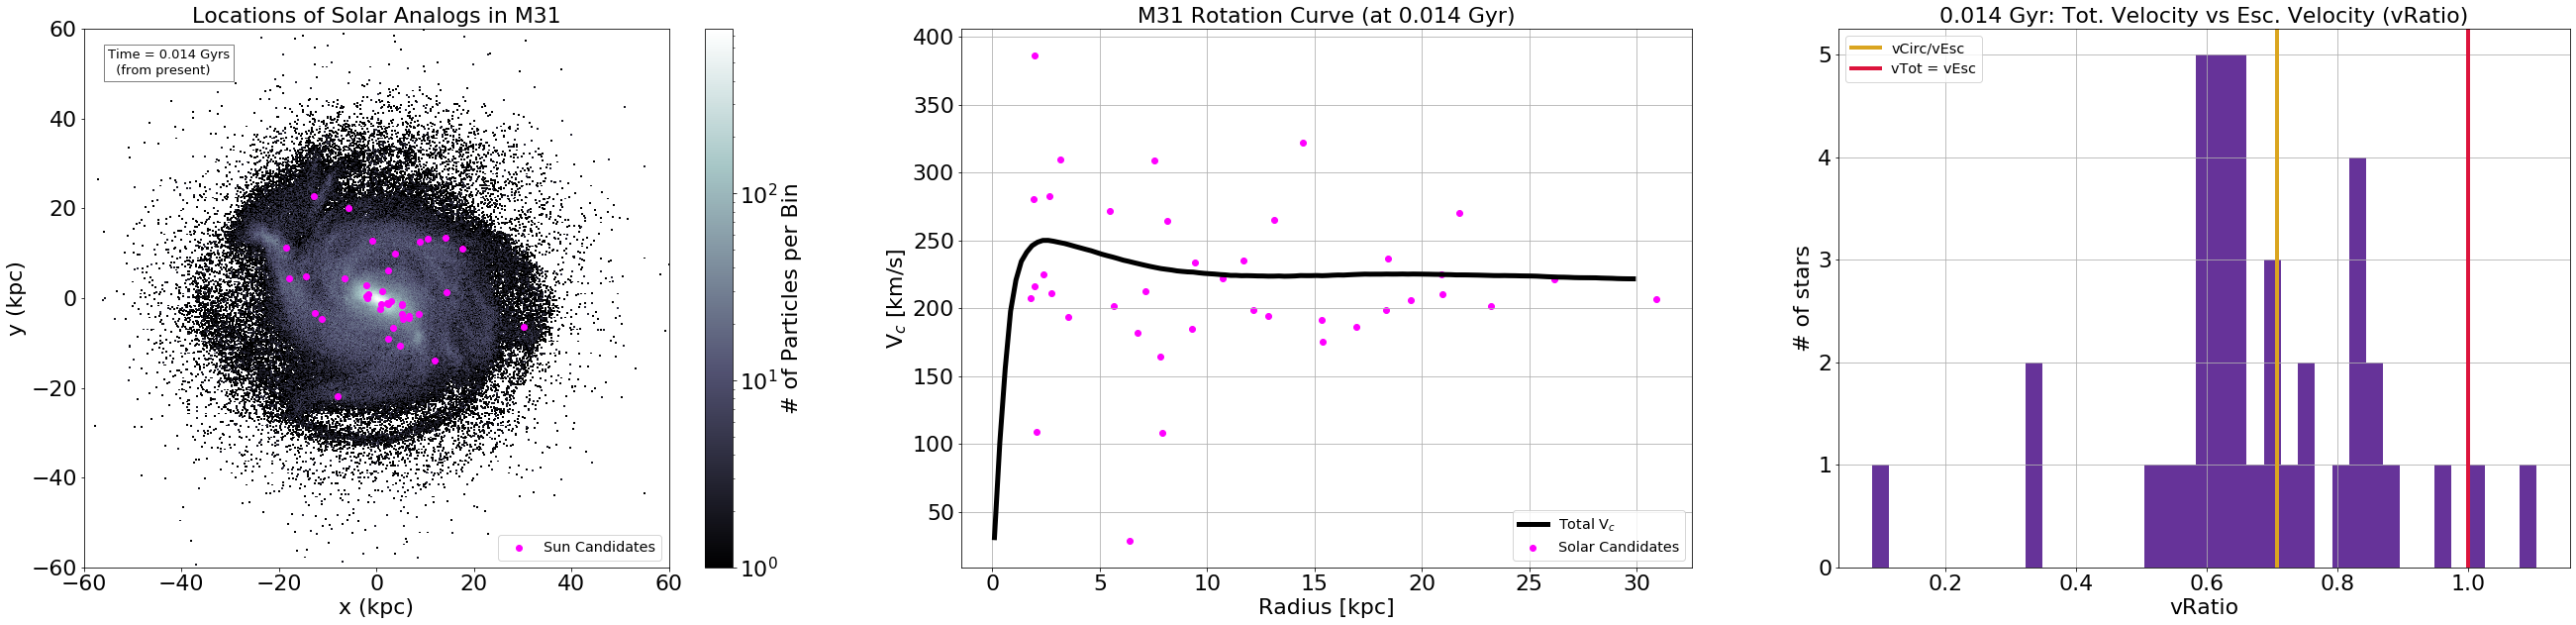

In [100]:
# 0.014 GYR

# setting up the subplots
fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(45, 10))

# ax[0] = PARTICLE DENSITY AND SOLAR CANDIDATE LOCATION
ax[0].annotate('Time = 0.014 Gyrs\n  (from present)', xy = (-55,50), size=13, bbox=dict(fc="white", ec="gray"))
# plot the particle density for M31 
hist = ax[0].hist2d(rDnew001[:,0], rDnew001[:,1], bins=700, norm = LogNorm(), cmap='bone')
# color coding
colorbar = plt.colorbar(hist[3], ax=ax[0])
# labeling the colorbar
colorbar.ax.set_ylabel('# of Particles per Bin', fontsize=22)
# plotting the candidate suns
ax[0].scatter(rDnew001[SunCandidates,0], rDnew001[SunCandidates,1], c='magenta', label='Sun Candidates')
# Adding a plot title
ax[0].set_title('Locations of Solar Analogs in M31', fontsize=22, loc='center', pad=None)
# Add axis labels
ax[0].set_xlabel('x (kpc)', fontsize=22)
ax[0].set_ylabel('y (kpc)', fontsize=22)
# making the axes equal
#ax[0].set_axis('scaled')
#set axis limits
ax[0].set_ylim(-60,60)
ax[0].set_xlim(-60,60)
# Adding a legend with some customizations.
ax[0].legend(loc='lower right',fontsize='x-large')


# ax[1] = ROTATION CURVE
# Plotting the rotation curve of M31
ax[1].plot(r0, M31VcTot001, color='black', linewidth=5, label='Total V$_c$')
# plotting the candidate suns
ax[1].scatter(RmagSuns001, VCircSuns001, c='magenta', label='Solar Candidates')
# Adding a plot title
# Displaying a grid
ax[1].grid(True, which="both")
ax[1].set_title('M31 Rotation Curve (at 0.014 Gyr)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[1].set_xlabel('Radius [kpc]', fontsize=22)
ax[1].set_ylabel('V$_c$ [km/s]', fontsize=22)
ax[1].legend(loc='lower right',fontsize='x-large')


# ax[2] = VRATIO HISTOGRAM
ax[2].hist(vRatio001,bins=39, color='rebeccapurple')
# Displaying a grid
ax[2].grid(True, which="both")
#Showing where stars on circular orbits would be
ax[2].axvline(x=CircEsc, ymin=0, ymax=1, color='goldenrod', linewidth=4, label='vCirc/vEsc')
#Showing where stars become "unbound"
ax[2].axvline(x=1.0, ymin=0, ymax=1, color='crimson', linewidth=4, label='vTot = vEsc')
# Adding a plot title
ax[2].set_title('0.014 Gyr: Tot. Velocity vs Esc. Velocity (vRatio)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[2].set_xlabel('vRatio', fontsize=22)
ax[2].set_ylabel('# of stars', fontsize=22)
ax[2].legend(loc='upper left',fontsize='x-large')

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('001TriplePlot.png', rasterized=True, dpi=350)

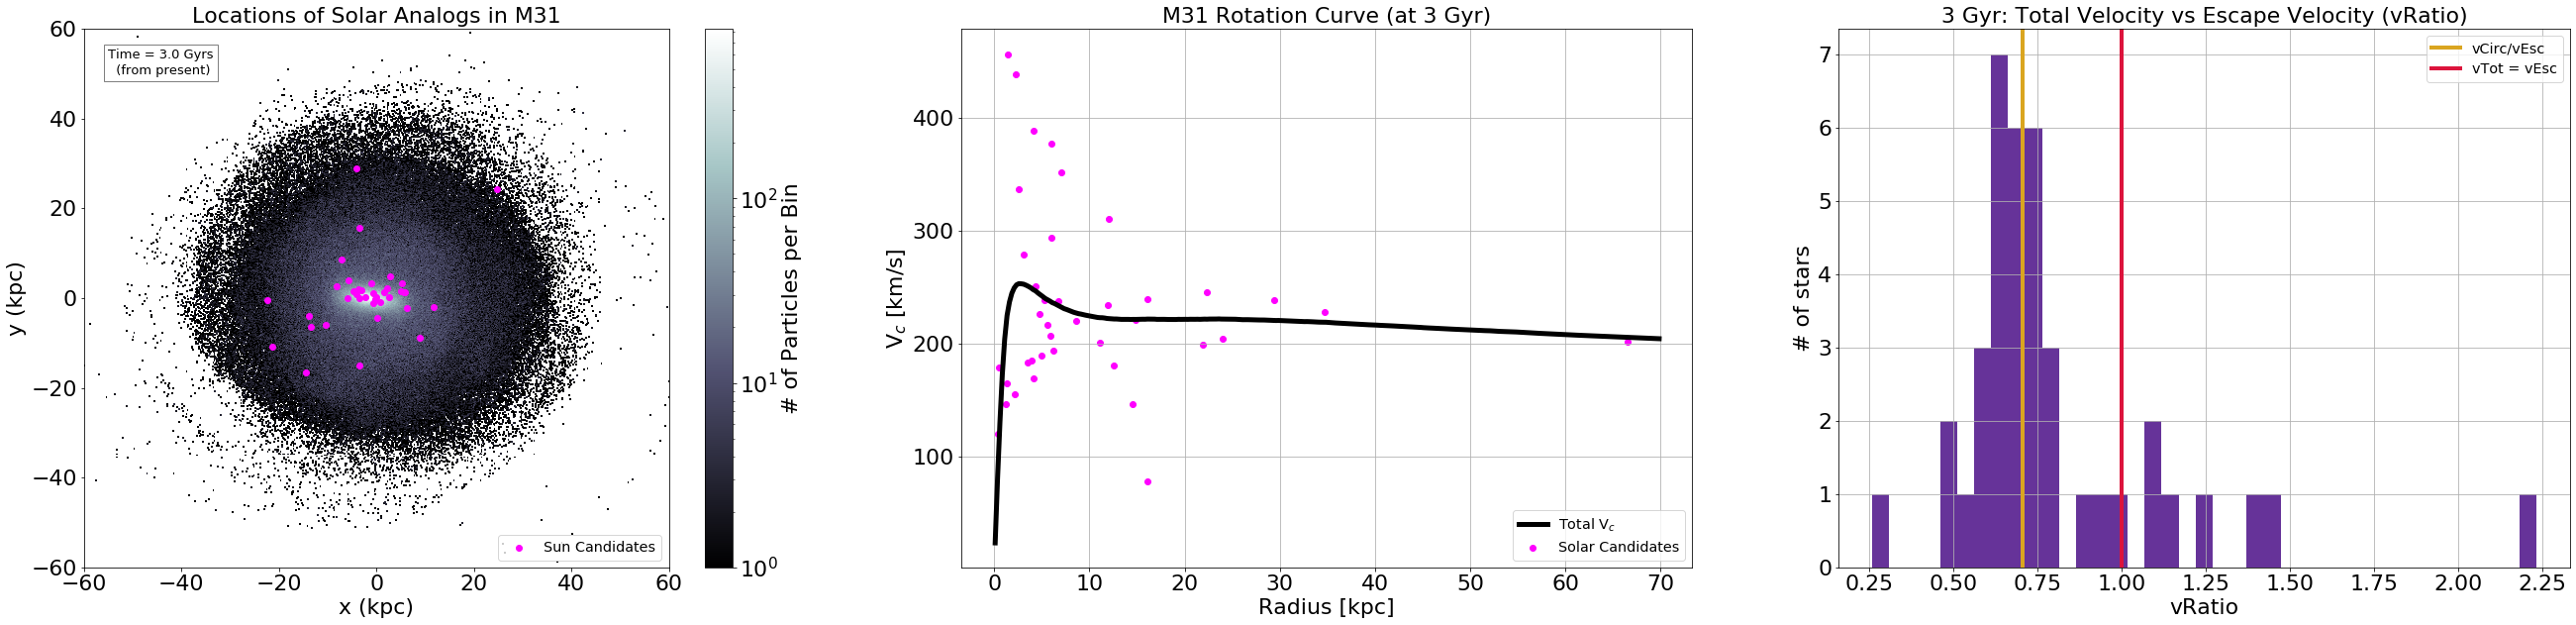

In [94]:
# 3 GYR

# setting up the subplots
fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(45, 10))

# ax[0] = PARTICLE DENSITY AND SOLAR CANDIDATE LOCATION
ax[0].annotate('Time = 3.0 Gyrs\n  (from present)', xy = (-55,50), size=13, bbox=dict(fc="white", ec="gray"))
# plot the particle density for M31 
hist = ax[0].hist2d(rDnew3[:,0], rDnew3[:,1], bins=700, norm = LogNorm(), cmap='bone')
# color coding
colorbar = plt.colorbar(hist[3], ax=ax[0])
# labeling the colorbar
colorbar.ax.set_ylabel('# of Particles per Bin', fontsize=22)
# plotting the candidate suns
ax[0].scatter(rDnew3[SunCandidates,0], rDnew3[SunCandidates,1], c='magenta', label='Sun Candidates')
# Adding a plot title
ax[0].set_title('Locations of Solar Analogs in M31', fontsize=22, loc='center', pad=None)
# Add axis labels
ax[0].set_xlabel('x (kpc)', fontsize=22)
ax[0].set_ylabel('y (kpc)', fontsize=22)
# making the axes equal
#ax[0].set_axis('scaled')
#set axis limits
ax[0].set_ylim(-60,60)
ax[0].set_xlim(-60,60)
# Adding a legend with some customizations.
ax[0].legend(loc='lower right',fontsize='x-large')


# ax[1] = ROTATION CURVE
# Plotting the rotation curve of M31
ax[1].plot(r3, M31VcTot3, color='black', linewidth=5, label='Total V$_c$')
# plotting the candidate suns
ax[1].scatter(RmagSuns3, VCircSuns3, c='magenta', label='Solar Candidates')
# Adding a plot title
# Displaying a grid
ax[1].grid(True, which="both")
ax[1].set_title('M31 Rotation Curve (at 3 Gyr)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[1].set_xlabel('Radius [kpc]', fontsize=22)
ax[1].set_ylabel('V$_c$ [km/s]', fontsize=22)
ax[1].legend(loc='lower right',fontsize='x-large')


# ax[2] = VRATIO HISTOGRAM
ax[2].hist(vRatio3,bins=39, color='rebeccapurple')
# Displaying a grid
ax[2].grid(True, which="both")
#Showing where stars on circular orbits would be
ax[2].axvline(x=CircEsc, ymin=0, ymax=1, color='goldenrod', linewidth=4, label='vCirc/vEsc')
#Showing where stars become "unbound"
ax[2].axvline(x=1.0, ymin=0, ymax=1, color='crimson', linewidth=4, label='vTot = vEsc')
# Adding a plot title
ax[2].set_title('3 Gyr: Total Velocity vs Escape Velocity (vRatio)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[2].set_xlabel('vRatio', fontsize=22)
ax[2].set_ylabel('# of stars', fontsize=22)
ax[2].legend(loc='upper right',fontsize='x-large')

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('03TriplePlot.png', rasterized=True, dpi=350)

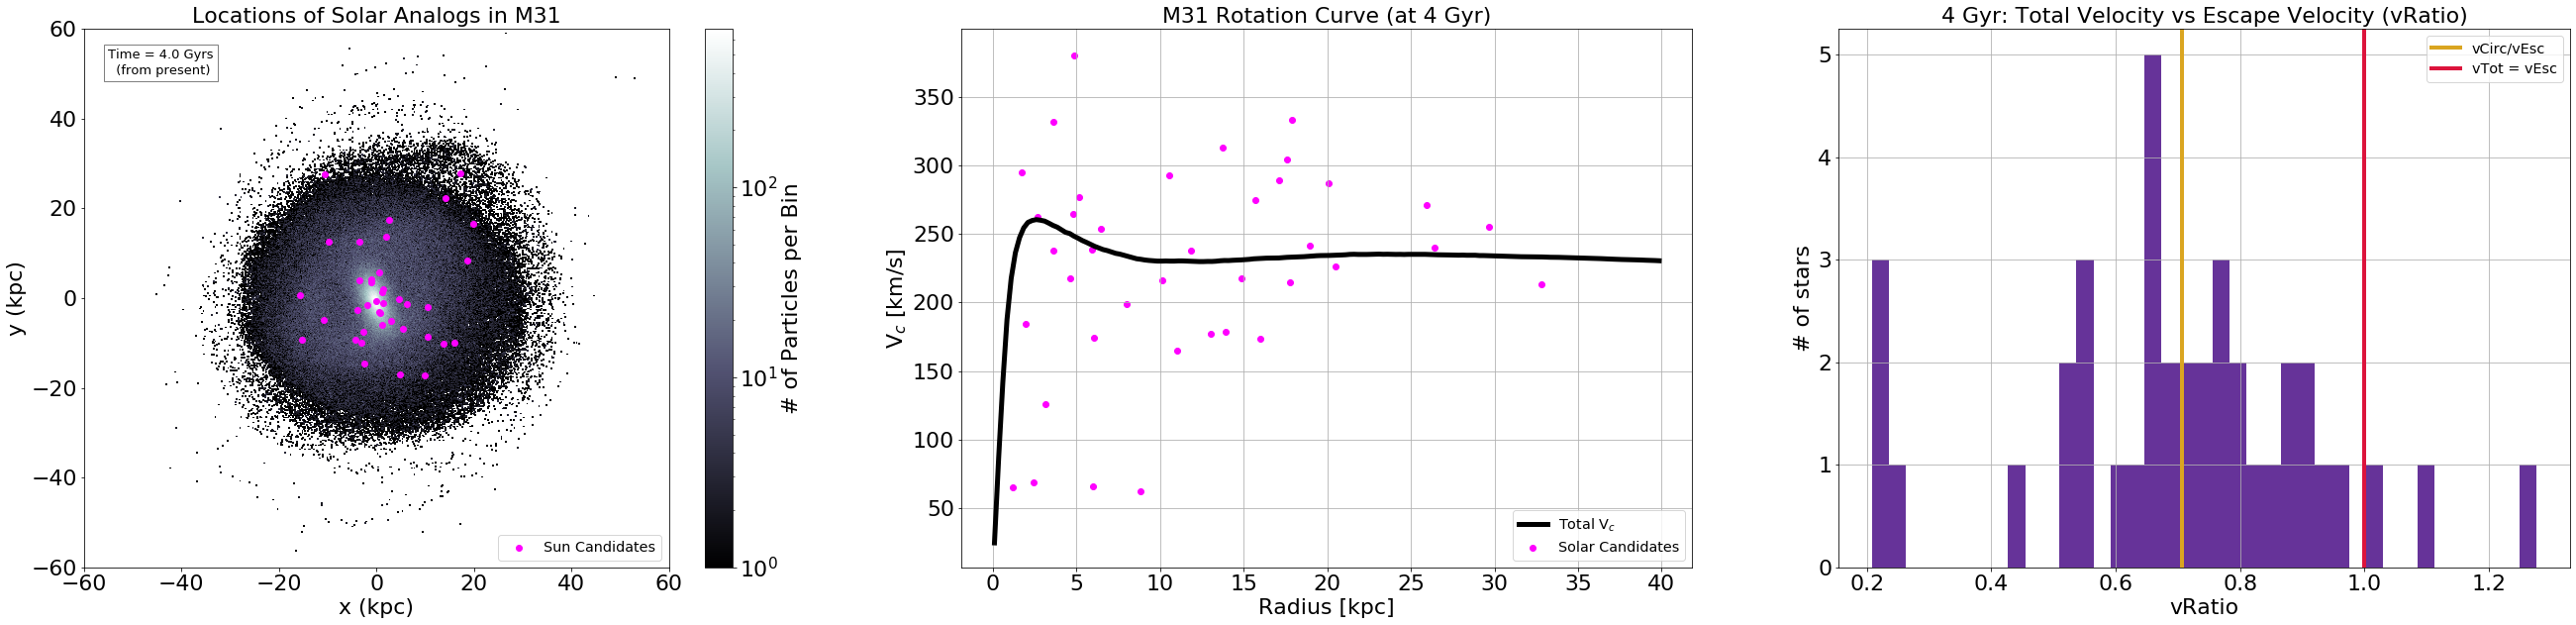

In [95]:
# 4 GYR

# setting up the subplots
fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(45, 10))

# ax[0] = PARTICLE DENSITY AND SOLAR CANDIDATE LOCATION
ax[0].annotate('Time = 4.0 Gyrs\n  (from present)', xy = (-55,50), size=13, bbox=dict(fc="white", ec="gray"))
# plot the particle density for M31 
hist = ax[0].hist2d(rDnew4[:,0], rDnew4[:,1], bins=700, norm = LogNorm(), cmap='bone')
# color coding
colorbar = plt.colorbar(hist[3], ax=ax[0])
# labeling the colorbar
colorbar.ax.set_ylabel('# of Particles per Bin', fontsize=22)
# plotting the candidate suns
ax[0].scatter(rDnew4[SunCandidates,0], rDnew4[SunCandidates,1], c='magenta', label='Sun Candidates')
# Adding a plot title
ax[0].set_title('Locations of Solar Analogs in M31', fontsize=22, loc='center', pad=None)
# Add axis labels
ax[0].set_xlabel('x (kpc)', fontsize=22)
ax[0].set_ylabel('y (kpc)', fontsize=22)
# making the axes equal
#ax[0].set_axis('scaled')
#set axis limits
ax[0].set_ylim(-60,60)
ax[0].set_xlim(-60,60)
# Adding a legend with some customizations.
ax[0].legend(loc='lower right',fontsize='x-large')


# ax[1] = ROTATION CURVE
# Plotting the rotation curve of M31
ax[1].plot(r4, M31VcTot4, color='black', linewidth=5, label='Total V$_c$')
# plotting the candidate suns
ax[1].scatter(RmagSuns4, VCircSuns4, c='magenta', label='Solar Candidates')
# Adding a plot title
# Displaying a grid
ax[1].grid(True, which="both")
ax[1].set_title('M31 Rotation Curve (at 4 Gyr)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[1].set_xlabel('Radius [kpc]', fontsize=22)
ax[1].set_ylabel('V$_c$ [km/s]', fontsize=22)
ax[1].legend(loc='lower right',fontsize='x-large')


# ax[2] = VRATIO HISTOGRAM
ax[2].hist(vRatio4,bins=39, color='rebeccapurple')
# Displaying a grid
ax[2].grid(True, which="both")
#Showing where stars on circular orbits would be
ax[2].axvline(x=CircEsc, ymin=0, ymax=1, color='goldenrod', linewidth=4, label='vCirc/vEsc')
#Showing where stars become "unbound"
ax[2].axvline(x=1.0, ymin=0, ymax=1, color='crimson', linewidth=4, label='vTot = vEsc')
# Adding a plot title
ax[2].set_title('4 Gyr: Total Velocity vs Escape Velocity (vRatio)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[2].set_xlabel('vRatio', fontsize=22)
ax[2].set_ylabel('# of stars', fontsize=22)
ax[2].legend(loc='upper right',fontsize='x-large')

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('04TriplePlot.png', rasterized=True, dpi=350)

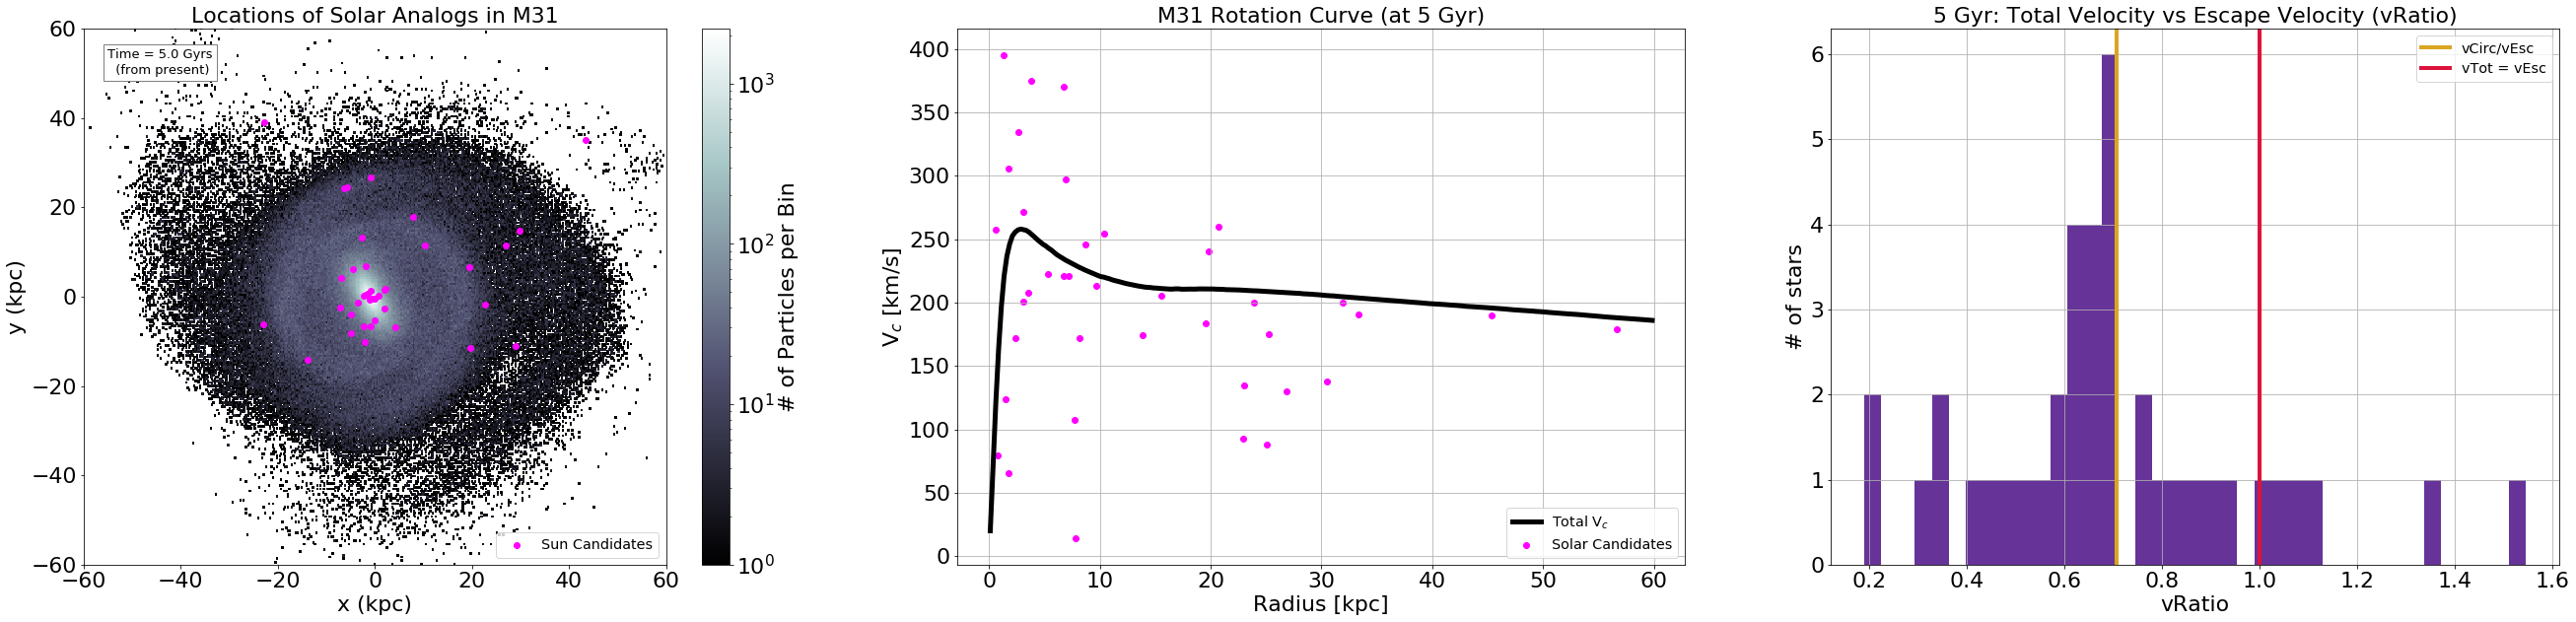

In [96]:
# 5 GYR

# setting up the subplots
fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(45, 10))

# ax[0] = PARTICLE DENSITY AND SOLAR CANDIDATE LOCATION
ax[0].annotate('Time = 5.0 Gyrs\n  (from present)', xy = (-55,50), size=13, bbox=dict(fc="white", ec="gray"))
# plot the particle density for M31 
hist = ax[0].hist2d(rDnew5[:,0], rDnew5[:,1], bins=700, norm = LogNorm(), cmap='bone')
# color coding
colorbar = plt.colorbar(hist[3], ax=ax[0])
# labeling the colorbar
colorbar.ax.set_ylabel('# of Particles per Bin', fontsize=22)
# plotting the candidate suns
ax[0].scatter(rDnew5[SunCandidates,0], rDnew5[SunCandidates,1], c='magenta', label='Sun Candidates')
# Adding a plot title
ax[0].set_title('Locations of Solar Analogs in M31', fontsize=22, loc='center', pad=None)
# Add axis labels
ax[0].set_xlabel('x (kpc)', fontsize=22)
ax[0].set_ylabel('y (kpc)', fontsize=22)
# making the axes equal
#ax[0].set_axis('scaled')
#set axis limits
ax[0].set_ylim(-60,60)
ax[0].set_xlim(-60,60)
# Adding a legend with some customizations.
ax[0].legend(loc='lower right',fontsize='x-large')


# ax[1] = ROTATION CURVE
# Plotting the rotation curve of M31
ax[1].plot(r8, M31VcTot5, color='black', linewidth=5, label='Total V$_c$')
# plotting the candidate suns
ax[1].scatter(RmagSuns5, VCircSuns5, c='magenta', label='Solar Candidates')
# Adding a plot title
# Displaying a grid
ax[1].grid(True, which="both")
ax[1].set_title('M31 Rotation Curve (at 5 Gyr)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[1].set_xlabel('Radius [kpc]', fontsize=22)
ax[1].set_ylabel('V$_c$ [km/s]', fontsize=22)
ax[1].legend(loc='lower right',fontsize='x-large')


# ax[2] = VRATIO HISTOGRAM
ax[2].hist(vRatio5,bins=39, color='rebeccapurple')
# Displaying a grid
ax[2].grid(True, which="both")
#Showing where stars on circular orbits would be
ax[2].axvline(x=CircEsc, ymin=0, ymax=1, color='goldenrod', linewidth=4, label='vCirc/vEsc')
#Showing where stars become "unbound"
ax[2].axvline(x=1.0, ymin=0, ymax=1, color='crimson', linewidth=4, label='vTot = vEsc')
# Adding a plot title
ax[2].set_title('5 Gyr: Total Velocity vs Escape Velocity (vRatio)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[2].set_xlabel('vRatio', fontsize=22)
ax[2].set_ylabel('# of stars', fontsize=22)
ax[2].legend(loc='upper right',fontsize='x-large')

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('05TriplePlot.png', rasterized=True, dpi=350)

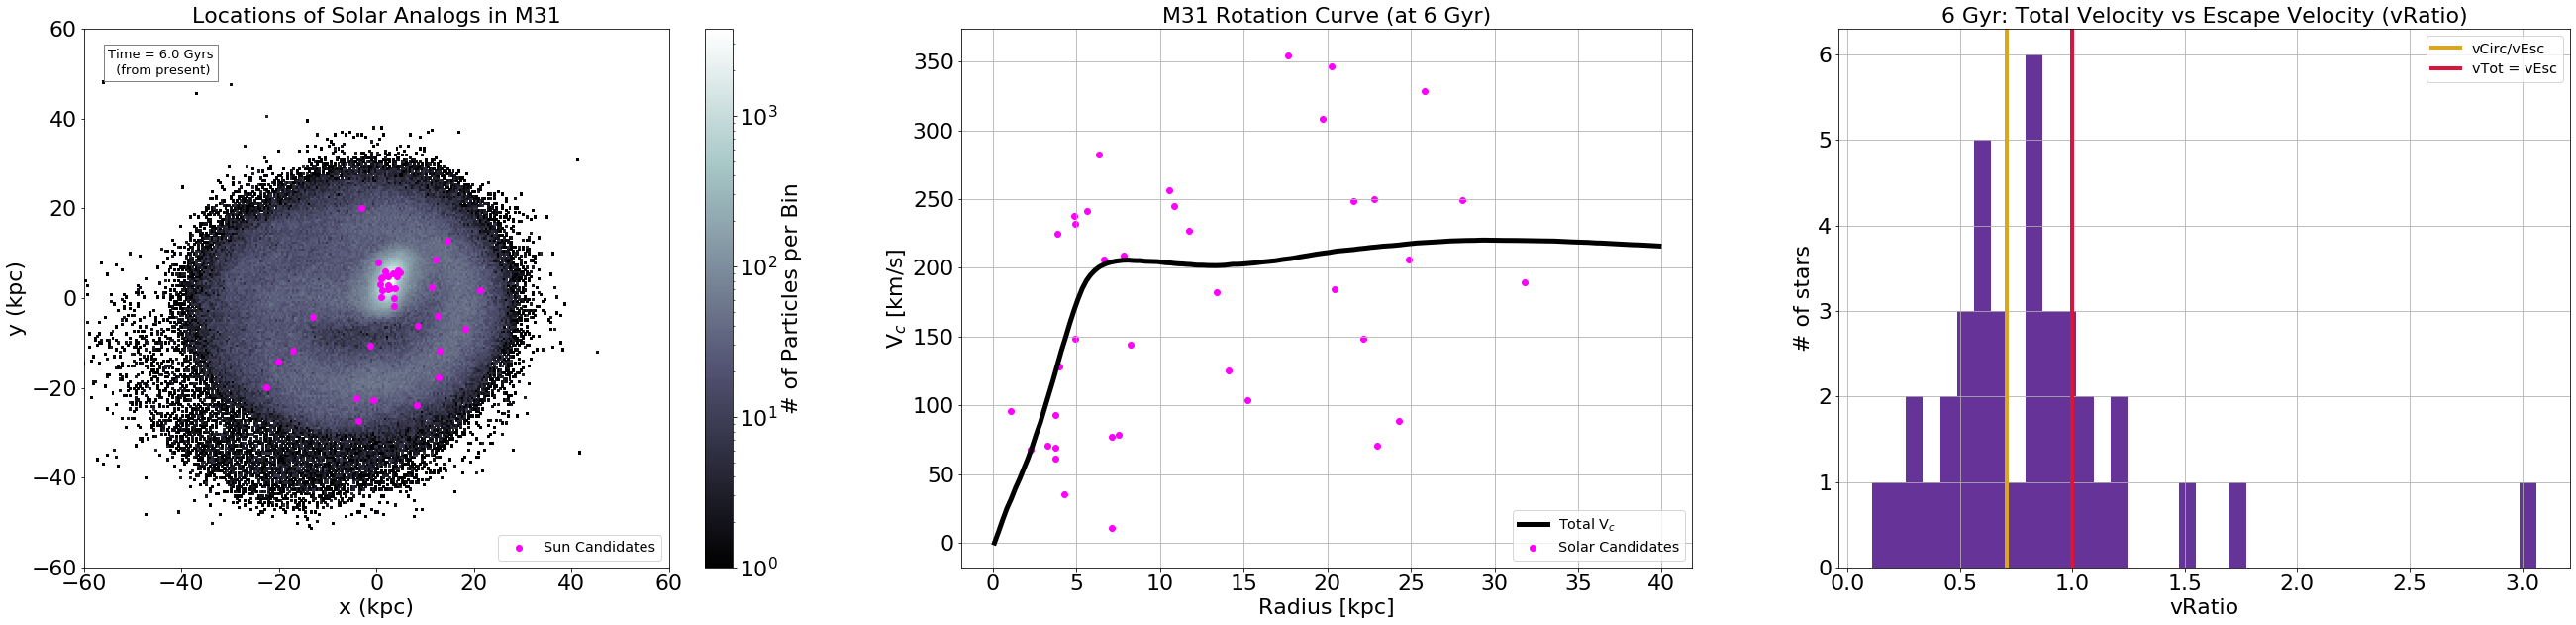

In [97]:
# 6 GYR

# setting up the subplots
fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(45, 10))

# ax[0] = PARTICLE DENSITY AND SOLAR CANDIDATE LOCATION
ax[0].annotate('Time = 6.0 Gyrs\n  (from present)', xy = (-55,50), size=13, bbox=dict(fc="white", ec="gray"))
# plot the particle density for M31 
hist = ax[0].hist2d(rDnew6[:,0], rDnew6[:,1], bins=700, norm = LogNorm(), cmap='bone')
# color coding
colorbar = plt.colorbar(hist[3], ax=ax[0])
# labeling the colorbar
colorbar.ax.set_ylabel('# of Particles per Bin', fontsize=22)
# plotting the candidate suns
ax[0].scatter(rDnew6[SunCandidates,0], rDnew6[SunCandidates,1], c='magenta', label='Sun Candidates')
# Adding a plot title
ax[0].set_title('Locations of Solar Analogs in M31', fontsize=22, loc='center', pad=None)
# Add axis labels
ax[0].set_xlabel('x (kpc)', fontsize=22)
ax[0].set_ylabel('y (kpc)', fontsize=22)
# making the axes equal
#ax[0].set_axis('scaled')
#set axis limits
ax[0].set_ylim(-60,60)
ax[0].set_xlim(-60,60)
# Adding a legend with some customizations.
ax[0].legend(loc='lower right',fontsize='x-large')


# ax[1] = ROTATION CURVE
# Plotting the rotation curve of M31
ax[1].plot(r4, M31VcTot6, color='black', linewidth=5, label='Total V$_c$')
# plotting the candidate suns
ax[1].scatter(RmagSuns6, VCircSuns6, c='magenta', label='Solar Candidates')
# Adding a plot title
# Displaying a grid
ax[1].grid(True, which="both")
ax[1].set_title('M31 Rotation Curve (at 6 Gyr)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[1].set_xlabel('Radius [kpc]', fontsize=22)
ax[1].set_ylabel('V$_c$ [km/s]', fontsize=22)
ax[1].legend(loc='lower right',fontsize='x-large')


# ax[2] = VRATIO HISTOGRAM
ax[2].hist(vRatio6,bins=39, color='rebeccapurple')
# Displaying a grid
ax[2].grid(True, which="both")
#Showing where stars on circular orbits would be
ax[2].axvline(x=CircEsc, ymin=0, ymax=1, color='goldenrod', linewidth=4, label='vCirc/vEsc')
#Showing where stars become "unbound"
ax[2].axvline(x=1.0, ymin=0, ymax=1, color='crimson', linewidth=4, label='vTot = vEsc')
# Adding a plot title
ax[2].set_title('6 Gyr: Total Velocity vs Escape Velocity (vRatio)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[2].set_xlabel('vRatio', fontsize=22)
ax[2].set_ylabel('# of stars', fontsize=22)
ax[2].legend(loc='upper right',fontsize='x-large')

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('06TriplePlot.png', rasterized=True, dpi=350)

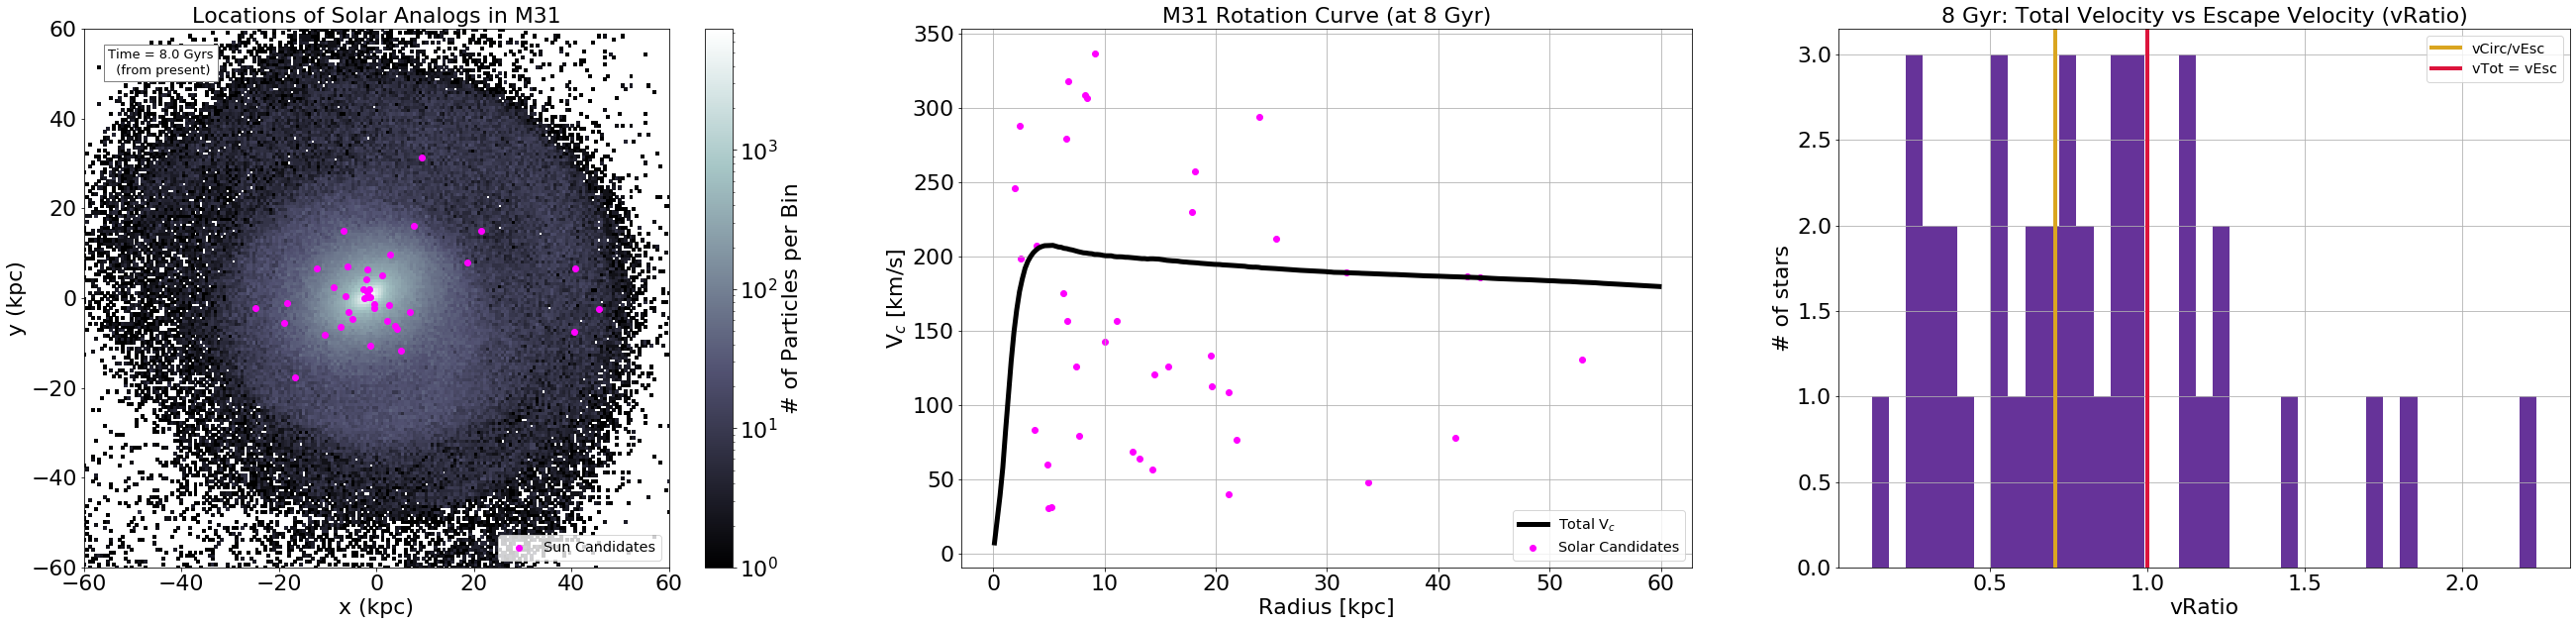

In [98]:
# 8 GYR

# setting up the subplots
fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(45, 10))


# ax[0] = PARTICLE DENSITY AND SOLAR CANDIDATE LOCATION
ax[0].annotate('Time = 8.0 Gyrs\n  (from present)', xy = (-55,50), size=13, bbox=dict(fc="white", ec="gray"))
# plot the particle density for M31 
hist = ax[0].hist2d(rDnew8[:,0], rDnew8[:,1], bins=700, norm = LogNorm(), cmap='bone')
# color coding
colorbar = plt.colorbar(hist[3], ax=ax[0])
# labeling the colorbar
colorbar.ax.set_ylabel('# of Particles per Bin', fontsize=22)
# plotting the candidate suns
ax[0].scatter(rDnew8[SunCandidates,0], rDnew8[SunCandidates,1], c='magenta', label='Sun Candidates')
# Adding a plot title
ax[0].set_title('Locations of Solar Analogs in M31', fontsize=22, loc='center', pad=None)
# Add axis labels
ax[0].set_xlabel('x (kpc)', fontsize=22)
ax[0].set_ylabel('y (kpc)', fontsize=22)
# making the axes equal
#ax[0].set_axis('scaled')
#set axis limits
ax[0].set_ylim(-60,60)
ax[0].set_xlim(-60,60)
# Adding a legend with some customizations.
ax[0].legend(loc='lower right',fontsize='x-large')


# ax[1] = ROTATION CURVE
# plotting the candidate suns
ax[1].scatter(RmagSuns8, VCircSuns8, c='magenta', label='Solar Candidates')
# Plotting the rotation curve of M31
ax[1].plot(r8, M31VcTot8, color='black', linewidth=5, label='Total V$_c$')
# Adding a plot title
# Displaying a grid
ax[1].grid(True, which="both")
ax[1].set_title('M31 Rotation Curve (at 8 Gyr)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[1].set_xlabel('Radius [kpc]', fontsize=22)
ax[1].set_ylabel('V$_c$ [km/s]', fontsize=22)
ax[1].legend(loc='lower right',fontsize='x-large')


# ax[2] = VRATIO HISTOGRAM
ax[2].hist(vRatio8,bins=39, color='rebeccapurple')
# Displaying a grid
ax[2].grid(True, which="both")
#Showing where stars on circular orbits would be
ax[2].axvline(x=CircEsc, ymin=0, ymax=1, color='goldenrod', linewidth=4, label='vCirc/vEsc')
#Showing where stars become "unbound"
ax[2].axvline(x=1.0, ymin=0, ymax=1, color='crimson', linewidth=4, label='vTot = vEsc')
# Adding a plot title
ax[2].set_title('8 Gyr: Total Velocity vs Escape Velocity (vRatio)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[2].set_xlabel('vRatio', fontsize=22)
ax[2].set_ylabel('# of stars', fontsize=22)
ax[2].legend(loc='upper right',fontsize='x-large')

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('08TriplePlot.png', rasterized=True, dpi=350)

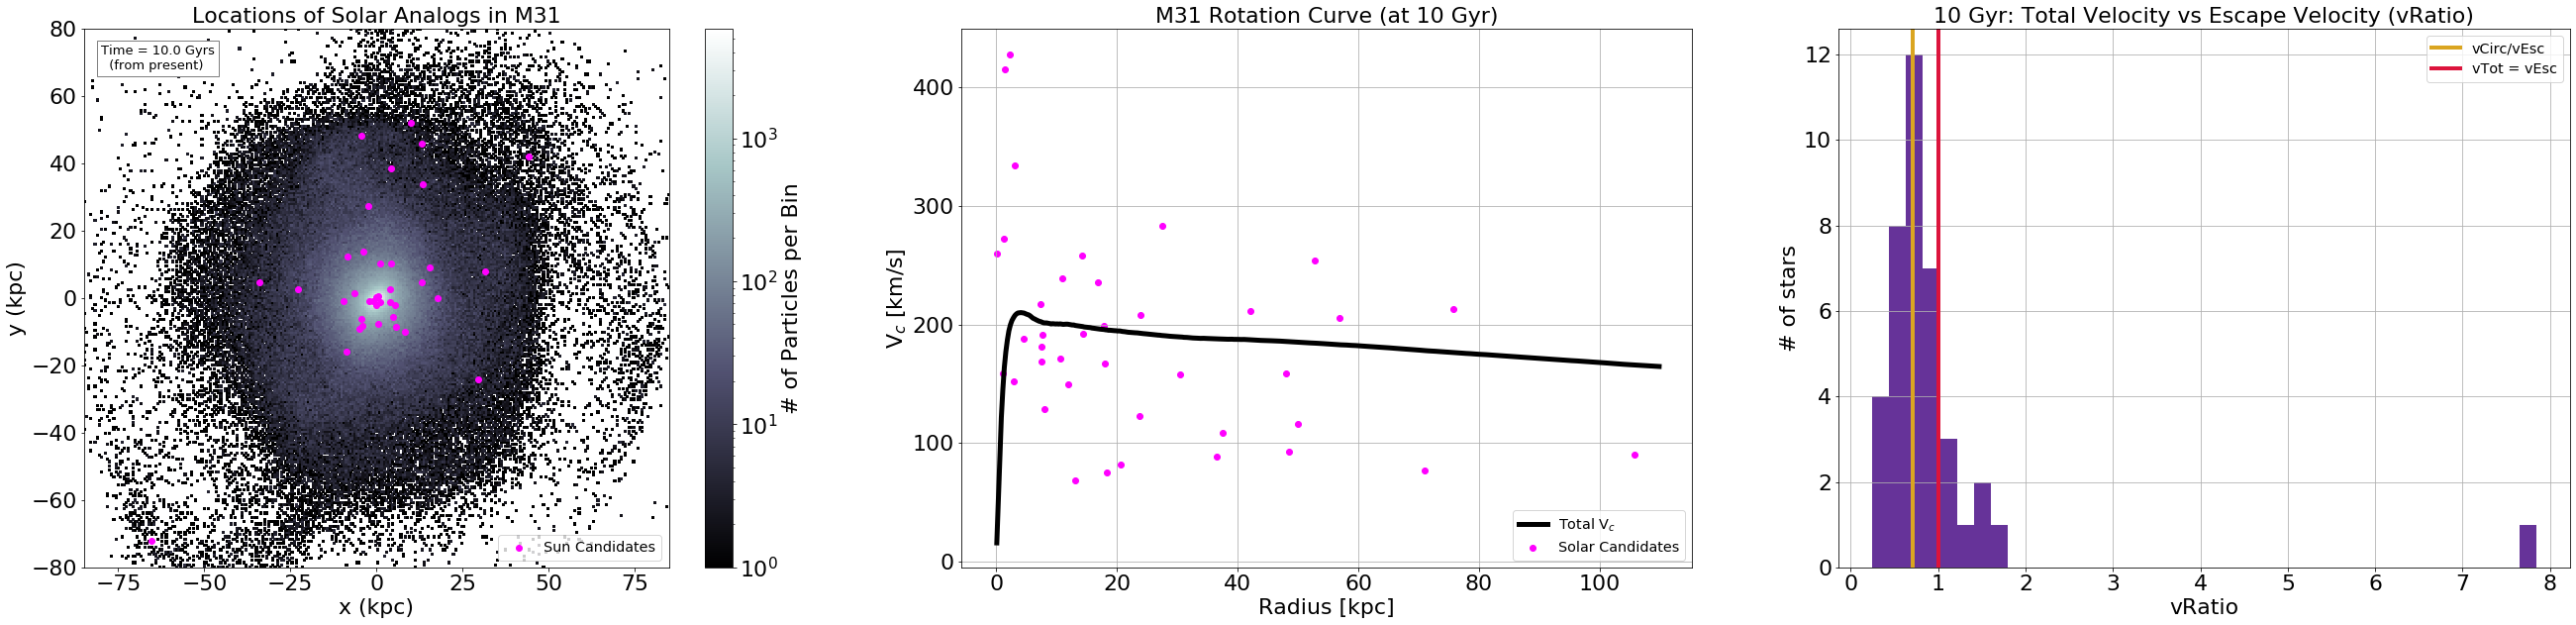

In [99]:
# 10 GYR

# setting up the subplots
fig, ax= plt.subplots(nrows=1, ncols=3, figsize=(45, 10))

# ax[0] = PARTICLE DENSITY AND SOLAR CANDIDATE LOCATION
ax[0].annotate('Time = 10.0 Gyrs\n  (from present)', xy = (-80,68), size=13, bbox=dict(fc="white", ec="gray"))
# plot the particle density for M31 
hist = ax[0].hist2d(rDnew10[:,0], rDnew10[:,1], bins=700, norm = LogNorm(), cmap='bone')
# color coding
colorbar = plt.colorbar(hist[3], ax=ax[0])
# labeling the colorbar
colorbar.ax.set_ylabel('# of Particles per Bin', fontsize=22)
# plotting the candidate suns
ax[0].scatter(rDnew10[SunCandidates,0], rDnew10[SunCandidates,1], c='magenta', label='Sun Candidates')
# Adding a plot title
ax[0].set_title('Locations of Solar Analogs in M31', fontsize=22, loc='center', pad=None)
# Add axis labels
ax[0].set_xlabel('x (kpc)', fontsize=22)
ax[0].set_ylabel('y (kpc)', fontsize=22)
# making the axes equal
#ax[0].set_axis('scaled')
#set axis limits
ax[0].set_ylim(-80,80)
ax[0].set_xlim(-85,85)

# Adding a legend with some customizations.
ax[0].legend(loc='lower right',fontsize='x-large')


# ax[1] = ROTATION CURVE
# Plotting the rotation curve of M31
ax[1].plot(r10, M31VcTot10, color='black', linewidth=5, label='Total V$_c$')
# plotting the candidate suns
ax[1].scatter(RmagSuns10, VCircSuns10, c='magenta', label='Solar Candidates')
# Adding a plot title
# Displaying a grid
ax[1].grid(True, which="both")
ax[1].set_title('M31 Rotation Curve (at 10 Gyr)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[1].set_xlabel('Radius [kpc]', fontsize=22)
ax[1].set_ylabel('V$_c$ [km/s]', fontsize=22)
ax[1].legend(loc='lower right',fontsize='x-large')


# ax[2] = VRATIO HISTOGRAM
ax[2].hist(vRatio10,bins=39, color='rebeccapurple')
# Displaying a grid
ax[2].grid(True, which="both")
#Showing where stars on circular orbits would be
ax[2].axvline(x=CircEsc, ymin=0, ymax=1, color='goldenrod', linewidth=4, label='vCirc/vEsc')
#Showing where stars become "unbound"
ax[2].axvline(x=1.0, ymin=0, ymax=1, color='crimson', linewidth=4, label='vTot = vEsc')
# Adding a plot title
ax[2].set_title('10 Gyr: Total Velocity vs Escape Velocity (vRatio)', fontsize=22, loc='center', pad=None)
# Adding axis labels
ax[2].set_xlabel('vRatio', fontsize=22)
ax[2].set_ylabel('# of stars', fontsize=22)
ax[2].legend(loc='upper right',fontsize='x-large')

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

plt.savefig('10TriplePlot.png', rasterized=True, dpi=350)

## stopped here

# Scrapped Stuff
# --------------------